## Convolutional Neural Net with RGB Reshaping and Scaling

In [152]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

from collections import defaultdict

import pickle
import time
import re

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [13]:
## function to read in the batch files
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin') # encoding latin otherwise no worky
    fo.close()
    return(dict)

In [14]:
def zero_center_pixels(data):
    scale = StandardScaler().fit(data)
    old_mean = scale.mean_.astype('float32')
    old_sigma = np.sqrt(scale.var_).astype('float32')
    return((data - old_mean) * 0.5 / old_sigma)

In [15]:
## read in the data
## manually is easy
data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')
label_map = unpickle('cifar-10-batches-py/batches.meta')

In [16]:
## stack up the data batches

## stack up the data batches
all_data = []

for i in data_batch_1['data']:
    all_data.append(i)
    
for i in data_batch_2['data']:
    all_data.append(i)

for i in data_batch_3['data']:
    all_data.append(i)

for i in data_batch_4['data']:
    all_data.append(i)
    
for i in data_batch_5['data']:
    all_data.append(i)

all_data = np.array(all_data)
print(all_data.shape)

(50000, 3072)


In [17]:
## stack up the label data
all_labels = data_batch_1['labels'] + data_batch_2['labels'] + data_batch_3['labels'] + data_batch_4['labels'] + data_batch_5['labels']
all_labels = np.array(all_labels)

test_labels = np.array(test_batch['labels'])

print(all_labels.shape)
print(test_labels.shape)

(50000,)
(10000,)


In [18]:
## scale and reshape the image data
all_data_rgb = zero_center_pixels(all_data).reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype('float32')
test_data_rgb = zero_center_pixels(test_batch['data']).reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype('float32')

/Users/xx/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/xx/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


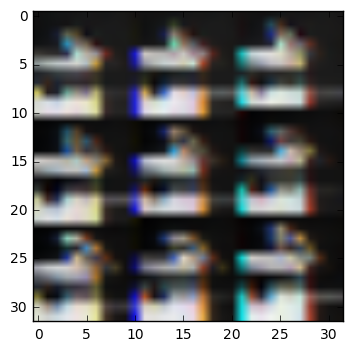

In [19]:
plt.imshow(all_data[13].reshape(32,32,3))
plt.show()

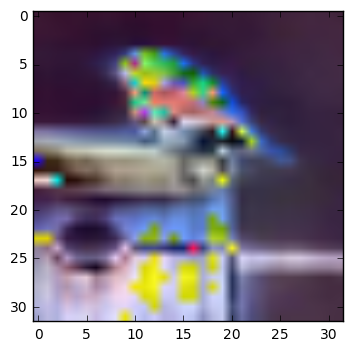

In [20]:
plt.imshow(all_data_rgb[13])
plt.show()

In [22]:
train_dataset = np.array(all_data_rgb)
train_labels = np.array(LabelBinarizer().fit_transform(all_labels))
test_dataset = np.array(test_data_rgb)
test_labels = np.array(LabelBinarizer().fit_transform(test_labels))
print('Train data shape: ', train_dataset.shape)
print('Train labels shape: ', train_labels.shape)
print('Test data shape: ', test_dataset.shape)
print('Test labels shape: ', test_labels.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 10)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 10)


---
- Step 5 -
============
Convolutional Neural Nets
---------

Now we turn to building a CNN using the architecture described in the TensorFlow website tutorial [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html). It will be a small network with two convolutional layers, followed by one fully connected layer. We'll limit the depth of this model so that it will run fine on the CPU and give a more elaborate architecture below that you can experiment with. Most production CNNs run on GPUs because they require more computation power. You can also find this example explained in Chapter 5 of [First Contact with TensorFlow](http://www.jorditorres.org/first-contact-with-tensorflow/) and in Chapter 5 of "Getting started with TensorFlow" available on [Proquest through Hollis](http://proquest.safaribooksonline.com.ezp-prod1.hul.harvard.edu/book/programming/machine-learning/9781786468574)

### Other useful references
There are also web books: Michael A. Nielsen, [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap6.html) and Goodfellow-et-al [Deep Learning](http://www.deeplearningbook.org/) (which is a preprint, available in HTML). There is also [Colah's blog](http://colah.github.io/) that explains convolutions and has some impressive visualizations. 

If you want to experiment hands-on with convolutions, then download [the GIMP](https://www.gimp.org/downloads/) (if you don't already have it), load up some of your favourite images, and then go to Filters $\rightarrow$ Generic $\rightarrow$ Convolution Matrix.  
[Here](https://docs.gimp.org/en/plug-in-convmatrix.html) are some examples.

---

### Choices to make in a CNN
* convolution kernel dimensions: the patch size (e.g. 5x5)
* stride length: 1, 2, something else
* the padding, SAME or VALID
* pooling: average or max pooling, pooling size  


To make the CNN, we will use two other `nn` functions in TensorFlow. The first is for the convolution itself, called [```tf.nn.conv2d()```](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#conv2d) . The function takes a 4D input tensor (hence the reformatting in the previous box), the weight variable and then both the stride and padding are specified as parameters.  

The second function is the pooling function, either [```tf.nn.max_pool```](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#max_pool) or [```tf.nn.avg_pool```](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#avg_pool). These functions take a 4D input tensor, along with the pooling size, the stride and the padding specified as parameters. We will show max_pool in the example.  

Note that between the parameters in convolution and the pooling, we have accumulated a number of hyper-parameters - this gives rise to a large number of options for tuning the best performing model, even without considering regularization/dropout and fully connected layers.

We redefine the weight and bias functions as per the TensorFlow example.

In [23]:
## this code was repurposed from Week 7 Section Jupyter Notebook

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [131]:
## this code was repurposed from Week 7 Section Jupyter Notebook

# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                #print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        #test_preds[name] = test_prediction.eval().ravel()

In [25]:
## this code was repurposed from Week 7 Section Jupyter Notebook

image_size = 32
num_labels = 10
num_channels = 3 # RGB
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return(tf.matmul(full3, layer4_weights) + layer4_biases)
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [28]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100001, "CNN", 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.3129420280456543
Minibatch accuracy: 6.2
Minibatch loss at epoch 500: 1.890977382659912
Minibatch accuracy: 18.8
Minibatch loss at epoch 1000: 1.9410686492919922
Minibatch accuracy: 18.8
Minibatch loss at epoch 1500: 1.1920980215072632
Minibatch accuracy: 62.5
Minibatch loss at epoch 2000: 1.445035457611084
Minibatch accuracy: 50.0
Minibatch loss at epoch 2500: 1.640390157699585
Minibatch accuracy: 50.0
Minibatch loss at epoch 3000: 1.9426970481872559
Minibatch accuracy: 43.8
Minibatch loss at epoch 3500: 1.856570839881897
Minibatch accuracy: 6.2
Minibatch loss at epoch 4000: 1.428167700767517
Minibatch accuracy: 37.5
Minibatch loss at epoch 4500: 1.7224122285842896
Minibatch accuracy: 50.0
Minibatch loss at epoch 5000: 0.9412868618965149
Minibatch accuracy: 68.8
Minibatch loss at epoch 5500: 2.008842945098877
Minibatch accuracy: 37.5
Minibatch loss at epoch 6000: 0.8360738754272461
Minibatch accuracy: 75.0
Minibatch loss at epoch 6500: 1.086742

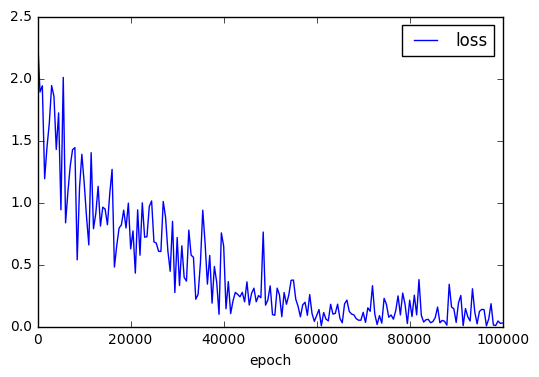

In [260]:
## copied and pasted the metrics above to text file
f = open('baseline_metrics.txt')
baseline_metrics = f.readlines()
baseline_metrics = [i for i in baseline_metrics if 'epoch' in i]
dict_list = []
for i in baseline_metrics:
    metrics_dict = {}
    epoch = re.search('at\sepoch\s(\d+)', i).group(1)
    loss = re.search('\d+\:\s(\d+\.\d+)', i).group(1)
    metrics_dict['epoch'] = int(epoch)
    metrics_dict['loss'] = np.float(loss.strip('\n'))
    dict_list.append(metrics_dict)

metrics_df = pd.DataFrame(dict_list)
metrics_df.plot(x = 'epoch', y = 'loss')
plt.show()

#### Running again, testing on rotated data

In [32]:
## create a distorted image test set
## rotate each image 90 degrees counterclockwise

rotated_test_dataset = []
for i in test_dataset:
    rotated_i = np.rot90(i)
    rotated_test_dataset.append(rotated_i)
rotated_test_dataset = np.array(rotated_test_dataset)

In [33]:
## this code was repurposed from Week 7 Section Jupyter Notebook
## same as the run above, just switching out the test data set

image_size = 32
num_labels = 10
num_channels = 3 # RGB
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(rotated_test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return(tf.matmul(full3, layer4_weights) + layer4_biases)
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [34]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100001, "CNN, rotated test", 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.3212242126464844
Minibatch accuracy: 6.2
Minibatch loss at epoch 500: 1.8319182395935059
Minibatch accuracy: 31.2
Minibatch loss at epoch 1000: 1.9347566366195679
Minibatch accuracy: 18.8
Minibatch loss at epoch 1500: 0.9801176190376282
Minibatch accuracy: 62.5
Minibatch loss at epoch 2000: 1.3293790817260742
Minibatch accuracy: 56.2
Minibatch loss at epoch 2500: 1.5515284538269043
Minibatch accuracy: 50.0
Minibatch loss at epoch 3000: 1.935272216796875
Minibatch accuracy: 37.5
Minibatch loss at epoch 3500: 1.772257685661316
Minibatch accuracy: 12.5
Minibatch loss at epoch 4000: 1.4469175338745117
Minibatch accuracy: 43.8
Minibatch loss at epoch 4500: 1.4962289333343506
Minibatch accuracy: 43.8
Minibatch loss at epoch 5000: 0.8714526295661926
Minibatch accuracy: 68.8
Minibatch loss at epoch 5500: 1.898965835571289
Minibatch accuracy: 25.0
Minibatch loss at epoch 6000: 0.9297059774398804
Minibatch accuracy: 75.0
Minibatch loss at epoch 6500: 1.25

## Training on less, stratified data

In [120]:
y_strats = [np.argmax(y) for y in all_labels]
X_AB, _, y_AB, _ = train_test_split(
    train_dataset, train_labels, test_size=0.33334, random_state=0, stratify=y_strats)

y_AB_strats = [np.argmax(y) for y in y_AB]
X_A, _, y_A, _ = train_test_split(
    X_AB, y_AB, test_size=0.5, random_state=0, stratify=y_AB_strats)

In [123]:
## this code was repurposed from Week 7 Section Jupyter Notebook
## added parameters for training input

# Re-define the function to include the keep probability
def run_session(num_epochs, name, train_dataset, train_labels, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                #print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        #test_preds[name] = test_prediction.eval().ravel()

In [124]:
## this code was repurposed from Week 7 Section Jupyter Notebook
## same as the run above, just switched back to the original test data set

image_size = 32
num_labels = 10
num_channels = 3 # RGB
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return(tf.matmul(full3, layer4_weights) + layer4_biases)
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [125]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100001, "CNN, rotated test", X_AB, y_AB, 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.3004541397094727
Minibatch accuracy: 18.8
Minibatch loss at epoch 500: 2.044785976409912
Minibatch accuracy: 18.8
Minibatch loss at epoch 1000: 2.019591808319092
Minibatch accuracy: 25.0
Minibatch loss at epoch 1500: 1.4678740501403809
Minibatch accuracy: 43.8
Minibatch loss at epoch 2000: 1.3694618940353394
Minibatch accuracy: 62.5
Minibatch loss at epoch 2500: 0.9977502822875977
Minibatch accuracy: 75.0
Minibatch loss at epoch 3000: 1.015858769416809
Minibatch accuracy: 62.5
Minibatch loss at epoch 3500: 0.995739758014679
Minibatch accuracy: 50.0
Minibatch loss at epoch 4000: 1.173172116279602
Minibatch accuracy: 56.2
Minibatch loss at epoch 4500: 1.0461037158966064
Minibatch accuracy: 75.0
Minibatch loss at epoch 5000: 1.0817272663116455
Minibatch accuracy: 56.2
Minibatch loss at epoch 5500: 1.1320512294769287
Minibatch accuracy: 50.0
Minibatch loss at epoch 6000: 1.7465558052062988
Minibatch accuracy: 50.0
Minibatch loss at epoch 6500: 0.978

In [126]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100001, "CNN, rotated test", X_A, y_A, 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.2884421348571777
Minibatch accuracy: 18.8
Minibatch loss at epoch 500: 2.030400514602661
Minibatch accuracy: 31.2
Minibatch loss at epoch 1000: 1.6359422206878662
Minibatch accuracy: 62.5
Minibatch loss at epoch 1500: 1.309079885482788
Minibatch accuracy: 43.8
Minibatch loss at epoch 2000: 1.6251078844070435
Minibatch accuracy: 43.8
Minibatch loss at epoch 2500: 1.6892971992492676
Minibatch accuracy: 56.2
Minibatch loss at epoch 3000: 1.433618426322937
Minibatch accuracy: 50.0
Minibatch loss at epoch 3500: 1.617576003074646
Minibatch accuracy: 50.0
Minibatch loss at epoch 4000: 1.391244888305664
Minibatch accuracy: 56.2
Minibatch loss at epoch 4500: 1.4553344249725342
Minibatch accuracy: 50.0
Minibatch loss at epoch 5000: 1.0619869232177734
Minibatch accuracy: 68.8
Minibatch loss at epoch 5500: 0.9485052824020386
Minibatch accuracy: 75.0
Minibatch loss at epoch 6000: 1.158582091331482
Minibatch accuracy: 56.2
Minibatch loss at epoch 6500: 1.0407

In [127]:
def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return(np.dot(ZCAMatrix, inputs))   #Data whitening

In [130]:
## this code was repurposed from Week 7 Section Jupyter Notebook
## same as the run above, just switched back to the original test data set

image_size = 32
num_labels = 10
num_channels = 3 # RGB
batch_size = 16
patch_size = 5
depth1 = 64
depth2 = 128
num_hidden = 2048

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return(tf.matmul(full3, layer4_weights) + layer4_biases)
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [132]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100001, "CNN, doubled parameters", 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.2848854064941406
Minibatch accuracy: 18.8
Minibatch loss at epoch 500: 1.850581169128418
Minibatch accuracy: 31.2
Minibatch loss at epoch 1000: 1.9311567544937134
Minibatch accuracy: 31.2
Minibatch loss at epoch 1500: 0.9471626281738281
Minibatch accuracy: 68.8
Minibatch loss at epoch 2000: 1.4252064228057861
Minibatch accuracy: 43.8
Minibatch loss at epoch 2500: 1.587514877319336
Minibatch accuracy: 43.8
Minibatch loss at epoch 3000: 1.7784273624420166
Minibatch accuracy: 37.5
Minibatch loss at epoch 3500: 1.8669697046279907
Minibatch accuracy: 12.5
Minibatch loss at epoch 4000: 1.4484093189239502
Minibatch accuracy: 43.8
Minibatch loss at epoch 4500: 1.4438533782958984
Minibatch accuracy: 50.0
Minibatch loss at epoch 5000: 0.7795445919036865
Minibatch accuracy: 75.0
Minibatch loss at epoch 5500: 1.8057217597961426
Minibatch accuracy: 37.5
Minibatch loss at epoch 6000: 0.9006322026252747
Minibatch accuracy: 75.0
Minibatch loss at epoch 6500: 0.

In [133]:
## this code was repurposed from Week 7 Section Jupyter Notebook
## same as the run above, just switched back to the original test data set

image_size = 32
num_labels = 10
num_channels = 3 # RGB
batch_size = 16
patch_size = 8
depth1 = 64
depth2 = 128
num_hidden = 2048

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return(tf.matmul(full3, layer4_weights) + layer4_biases)
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [134]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100001, "CNN, doubled parameters, patch size 8", 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.2985620498657227
Minibatch accuracy: 12.5
Minibatch loss at epoch 500: 1.8623961210250854
Minibatch accuracy: 31.2
Minibatch loss at epoch 1000: 1.8926243782043457
Minibatch accuracy: 37.5
Minibatch loss at epoch 1500: 0.9991700649261475
Minibatch accuracy: 62.5
Minibatch loss at epoch 2000: 1.5030403137207031
Minibatch accuracy: 31.2
Minibatch loss at epoch 2500: 1.6738585233688354
Minibatch accuracy: 43.8
Minibatch loss at epoch 3000: 1.8175153732299805
Minibatch accuracy: 37.5
Minibatch loss at epoch 3500: 1.781968593597412
Minibatch accuracy: 31.2
Minibatch loss at epoch 4000: 1.4873465299606323
Minibatch accuracy: 37.5
Minibatch loss at epoch 4500: 1.421877384185791
Minibatch accuracy: 56.2
Minibatch loss at epoch 5000: 0.9442100524902344
Minibatch accuracy: 75.0
Minibatch loss at epoch 5500: 1.877824068069458
Minibatch accuracy: 37.5
Minibatch loss at epoch 6000: 0.9926328659057617
Minibatch accuracy: 62.5
Minibatch loss at epoch 6500: 0.7

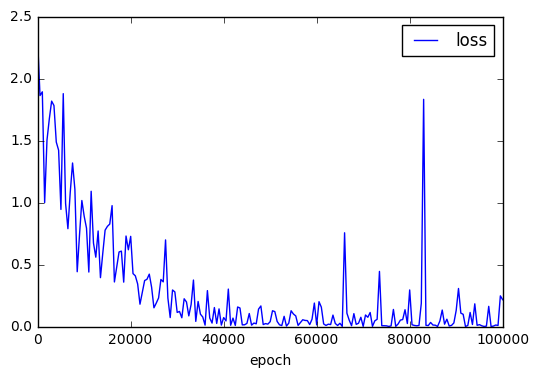

In [337]:
## copied and pasted the metrics above to text file
f = open('baseline_metrics.txt')
baseline_metrics = f.readlines()
baseline_metrics = [i for i in baseline_metrics if 'epoch' in i]
dict_list = []
for i in baseline_metrics:
    metrics_dict = {}
    epoch = re.search('at\sepoch\s(\d+)', i).group(1)
    loss = re.search('\d+\:\s(\d+\.\d+)', i).group(1)
    metrics_dict['epoch'] = int(epoch)
    metrics_dict['loss'] = np.float(loss.strip('\n'))
    dict_list.append(metrics_dict)

metrics_df = pd.DataFrame(dict_list)
metrics_df.plot(x = 'epoch', y = 'loss')
plt.show()

In [409]:
## this code was repurposed from Week 7 Section Jupyter Notebook
## same as the run above, just switched back to the original test data set

image_size = 32
num_labels = 10
num_channels = 3 # RGB
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return(tf.matmul(full3, layer4_weights) + layer4_biases)
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdadeltaOptimizer(1e-5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))
    


In [410]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100000, "CNN, baseline, adadelt", 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.298297643661499
Minibatch accuracy: 6.2
Minibatch loss at epoch 500: 2.3129405975341797
Minibatch accuracy: 18.8
Minibatch loss at epoch 1000: 2.3166544437408447
Minibatch accuracy: 6.2
Minibatch loss at epoch 1500: 2.299283981323242
Minibatch accuracy: 18.8
Minibatch loss at epoch 2000: 2.3011209964752197
Minibatch accuracy: 18.8
Minibatch loss at epoch 2500: 2.309901237487793
Minibatch accuracy: 6.2
Minibatch loss at epoch 3000: 2.2793917655944824
Minibatch accuracy: 25.0
Minibatch loss at epoch 3500: 2.2921993732452393
Minibatch accuracy: 31.2
Minibatch loss at epoch 4000: 2.2835633754730225
Minibatch accuracy: 12.5
Minibatch loss at epoch 4500: 2.296804904937744
Minibatch accuracy: 12.5
Minibatch loss at epoch 5000: 2.3018927574157715
Minibatch accuracy: 6.2
Minibatch loss at epoch 5500: 2.2937722206115723
Minibatch accuracy: 25.0
Minibatch loss at epoch 6000: 2.300999164581299
Minibatch accuracy: 6.2
Minibatch loss at epoch 6500: 2.31208896

In [411]:
## this code was repurposed from Week 7 Section Jupyter Notebook
## same as the run above, just switched back to the original test data set

image_size = 32
num_labels = 10
num_channels = 3 # RGB
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return(tf.matmul(full3, layer4_weights) + layer4_biases)
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [ ]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100000, "CNN, baseline", 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.299144744873047
Minibatch accuracy: 6.2
Minibatch loss at epoch 500: 2.1940410137176514
Minibatch accuracy: 18.8
Minibatch loss at epoch 1000: 2.464351177215576
Minibatch accuracy: 12.5
Minibatch loss at epoch 1500: 1.7275880575180054
Minibatch accuracy: 50.0
Minibatch loss at epoch 2000: 2.029294967651367
Minibatch accuracy: 25.0
Minibatch loss at epoch 2500: 1.9166455268859863
Minibatch accuracy: 18.8
Minibatch loss at epoch 3000: 1.9255473613739014
Minibatch accuracy: 37.5
Minibatch loss at epoch 3500: 2.150907516479492
Minibatch accuracy: 12.5
Minibatch loss at epoch 4000: 1.6005074977874756
Minibatch accuracy: 43.8
Minibatch loss at epoch 4500: 2.0382068157196045
Minibatch accuracy: 31.2
Minibatch loss at epoch 5000: 1.5129921436309814
Minibatch accuracy: 62.5
Minibatch loss at epoch 5500: 1.9159517288208008
Minibatch accuracy: 37.5
Minibatch loss at epoch 6000: 1.7113233804702759
Minibatch accuracy: 31.2
Minibatch loss at epoch 6500: 1.859